In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_dir = '/content/drive/MyDrive/NICOS_NN/SOLSTICIO2_0'
input_pkl_path_v1 = os.path.join(data_dir, 'input_nn_ver1.pkl')
#input_pkl_path_v2 = os.path.join(data_dir, 'input_nn_ver2.pkl')

In [4]:
df = pd.read_pickle(input_pkl_path_v1)
#df = pd.read_pickle(input_pkl_path_v2)

**------------------NOISE ADDING----------------------**

In [5]:
def add_noise(tsky, trx=75.0, snr=1000.0):
    tsys = trx + tsky
    tnoise = tsys / snr
    tcal = tsky + tnoise * np.random.standard_normal(tsky.shape)
    return tcal

In [6]:
original_spectrum = np.array(df['SPECTRA_Tb[K]'].iloc[0])

In [7]:
frequencies = np.linspace(20.0, 26.0, len(original_spectrum))

In [8]:
noisy_spectrum = add_noise(original_spectrum)

In [9]:
df['SPECTRA_Tb[K]_NOISY'] = df['SPECTRA_Tb[K]'].apply(lambda spec: add_noise(np.array(spec)))

**TRANING WAY 1: USING DIFFERENT COLUMNS BETWEEN PL AND H2O**

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
X = np.array(df['SPECTRA_Tb[K]_NOISY'].tolist())
PL = np.array(df['PL[mbar]'].tolist())
H2O = np.array(df['H2O[vmr]'].tolist())
Y = np.concatenate([PL, H2O], axis=1)

In [12]:
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.4, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

In [13]:
print("X_train:", X_train.shape)
print("X_val:  ", X_val.shape)
print("X_test: ", X_test.shape)

X_train: (12614, 12001)
X_val:   (4205, 12001)
X_test:  (4205, 12001)


In [14]:
print("Y_train:", Y_train.shape)
print("Y_val:  ", Y_val.shape)
print("Y_test: ", Y_test.shape)

Y_train: (12614, 134)
Y_val:   (4205, 134)
Y_test:  (4205, 134)


**SECOND FRAMEWORK TORCH**

In [15]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


**-NORMALIZATION-**

In [16]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
#X_train_scaled = scaler.fit_transform(X_train)
#X_val_scaled = scaler.transform(X_val)
#X_test_scaled = scaler.transform(X_test)
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

**-----------------------**

In [17]:
X_train = torch.tensor(X_train, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.float32)
X_val   = torch.tensor(X_val, dtype=torch.float32)
Y_val   = torch.tensor(Y_val, dtype=torch.float32)
X_test  = torch.tensor(X_test, dtype=torch.float32)
Y_test  = torch.tensor(Y_test, dtype=torch.float32)

In [18]:
batch_size = 64

In [19]:
train_ds = TensorDataset(X_train, Y_train)
val_ds   = TensorDataset(X_val, Y_val)
test_ds  = TensorDataset(X_test, Y_test)

In [20]:
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

In [21]:
class PedroMLP(nn.Module):
    def __init__(self):
        super(PedroMLP, self).__init__()
        self.fc1 = nn.Linear(12001, 1024)
        self.dropout1 = nn.Dropout(p=0.4)
        self.fc2 = nn.Linear(1024, 512)
        self.dropout2 = nn.Dropout(p=0.4)
        self.fc3 = nn.Linear(512, 256)
        self.dropout3 = nn.Dropout(p=0.4)
        self.fc4 = nn.Linear(256, 128)
        self.dropout4 = nn.Dropout(p=0.4)
        self.fc5 = nn.Linear(128, 134)  # 67 H2O + 67 PL

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = torch.relu(self.fc3(x))
        x = self.dropout3(x)
        x = torch.relu(self.fc4(x))
        x = self.dropout4(x)
        x = self.fc5(x)
        return x

In [22]:
model = PedroMLP()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [23]:
def train(model, loader, val_loader, criterion, optimizer, epochs):
    train_losses, val_losses = [], []
    val_mae_list, val_rmse_list = [], []

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for xb, yb in loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        train_losses.append(epoch_loss / len(loader))

        model.eval()
        val_loss = 0
        y_true, y_pred = [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                preds = model(xb)
                val_loss += criterion(preds, yb).item()
                y_true.append(yb.numpy())
                y_pred.append(preds.numpy())

        val_losses.append(val_loss / len(val_loader))

        y_true = np.concatenate(y_true, axis=0)
        y_pred = np.concatenate(y_pred, axis=0)

        val_mae = mean_absolute_error(y_true, y_pred)
        val_rmse = np.sqrt(mean_squared_error(y_true, y_pred))

        val_mae_list.append(val_mae)
        val_rmse_list.append(val_rmse)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f} | MAE: {val_mae:.4f} | RMSE: {val_rmse:.4f}")

    return train_losses, val_losses, val_mae_list, val_rmse_list

In [24]:
def evaluate(model, loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for xb, yb in loader:
            preds = model(xb)
            y_true.append(yb.numpy())
            y_pred.append(preds.numpy())
    y_true = np.concatenate(y_true, axis=0)
    y_pred = np.concatenate(y_pred, axis=0)
    return y_true, y_pred

In [25]:
epochs = 50
train_losses, val_losses, val_mae, val_rmse = train(model, train_loader, val_loader, criterion, optimizer, epochs)

Epoch 1/50 | Train Loss: 47622.1543 | Val Loss: 37221.0210 | MAE: 80.3151 | RMSE: 192.8991
Epoch 2/50 | Train Loss: 36588.0216 | Val Loss: 26400.1815 | MAE: 67.1916 | RMSE: 162.4648
Epoch 3/50 | Train Loss: 27454.7852 | Val Loss: 21546.6481 | MAE: 58.6024 | RMSE: 146.7646
Epoch 4/50 | Train Loss: 25070.4710 | Val Loss: 22680.2652 | MAE: 58.1658 | RMSE: 150.6107
Epoch 5/50 | Train Loss: 24051.0117 | Val Loss: 25934.9879 | MAE: 65.3027 | RMSE: 161.0128
Epoch 6/50 | Train Loss: 23757.8710 | Val Loss: 22729.8842 | MAE: 60.1634 | RMSE: 150.7693
Epoch 7/50 | Train Loss: 23123.0520 | Val Loss: 22280.5597 | MAE: 58.3862 | RMSE: 149.2850
Epoch 8/50 | Train Loss: 23491.6837 | Val Loss: 19228.3218 | MAE: 53.3543 | RMSE: 138.6730
Epoch 9/50 | Train Loss: 22001.3688 | Val Loss: 18723.3655 | MAE: 54.1628 | RMSE: 136.8332
Epoch 10/50 | Train Loss: 22227.5266 | Val Loss: 18131.2150 | MAE: 51.5374 | RMSE: 134.6381
Epoch 11/50 | Train Loss: 21439.5614 | Val Loss: 18917.4730 | MAE: 53.5423 | RMSE: 137.52

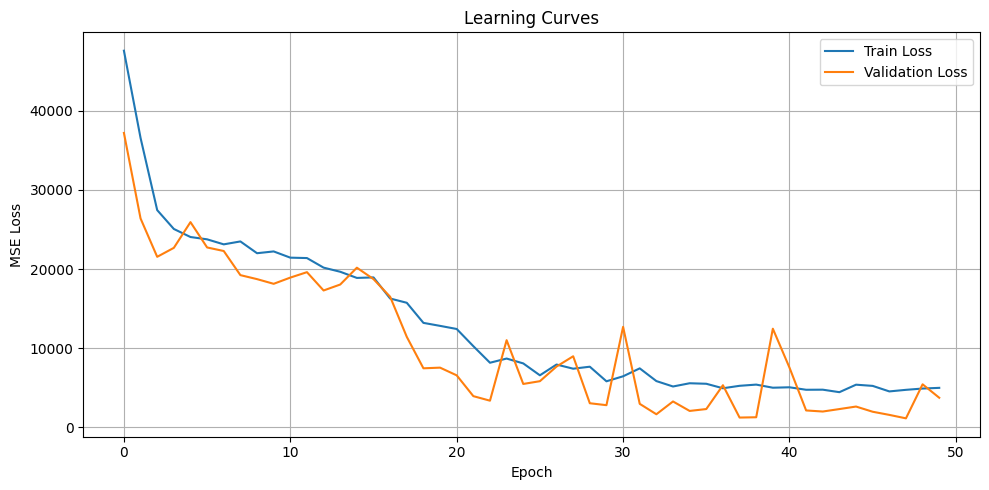

In [26]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Learning Curves')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [27]:
y_true_test, y_pred_test = evaluate(model, test_loader)

# Compute test metrics
test_mae = mean_absolute_error(y_true_test, y_pred_test)
test_rmse = np.sqrt(mean_squared_error(y_true_test, y_pred_test))
test_r2 = r2_score(y_true_test, y_pred_test)

print(f"\nTest MAE: {test_mae:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test R²: {test_r2:.4f}")


Test MAE: 21.8796
Test RMSE: 61.3987
Test R²: -6112215040000.0000


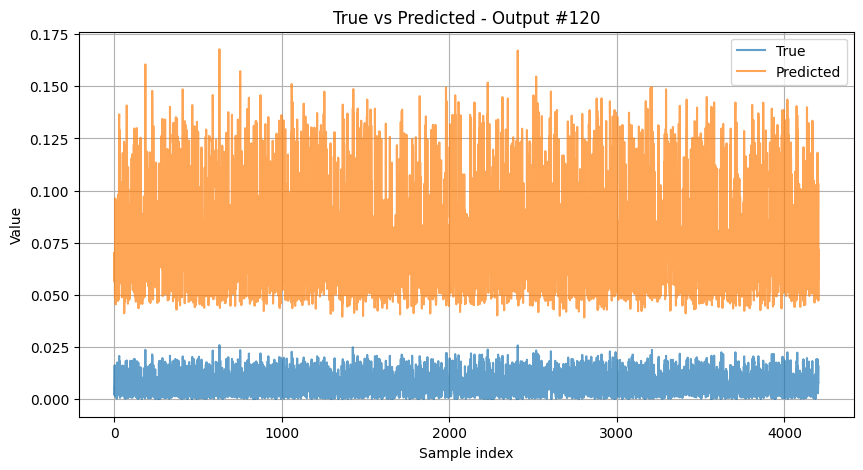

In [28]:
output_index = 120  # choose any from 0 to 133

plt.figure(figsize=(10, 5))
plt.plot(y_true_test[:, output_index], label='True', alpha=0.7)
plt.plot(y_pred_test[:, output_index], label='Predicted', alpha=0.7)
plt.title(f"True vs Predicted - Output #{output_index}")
plt.xlabel("Sample index")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

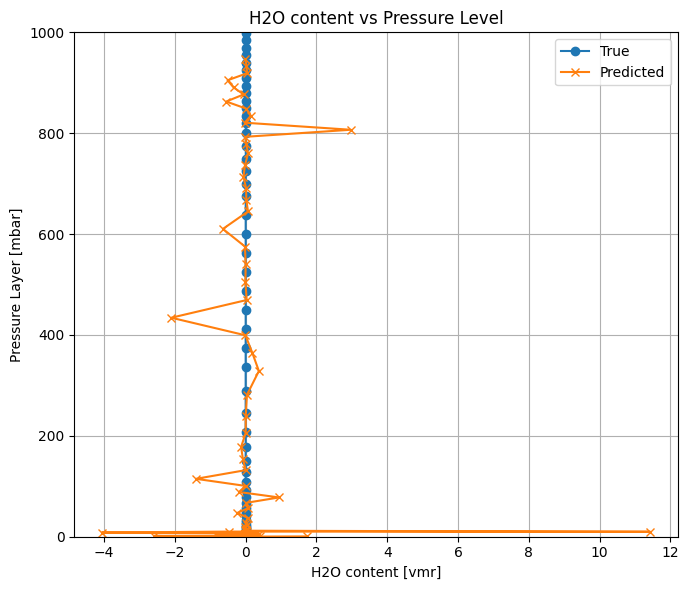

In [29]:
# Split predictions and true labels
n_levels = y_true_test.shape[1] // 2  # 67 H2O + 67 PL

PL_true = y_true_test[:, :n_levels]
H2O_true = y_true_test[:, n_levels:]

PL_pred = y_pred_test[:, :n_levels]
H2O_pred = y_pred_test[:, n_levels:]

# Choose a sample index
i = 0  # change to visualize different examples

# Extract profiles
pl_profile_true = PL_true[i]
h2o_profile_true = H2O_true[i]

pl_profile_pred = PL_pred[i]
h2o_profile_pred = H2O_pred[i]

# Plot both true and predicted on same plot
plt.figure(figsize=(7, 6))
plt.plot(h2o_profile_true, pl_profile_true, label="True", marker='o')
plt.plot(h2o_profile_pred, pl_profile_pred, label="Predicted", marker='x')
plt.gca().invert_yaxis()
plt.xlabel("H2O content [vmr]")
plt.ylabel("Pressure Layer [mbar]")
plt.ylim(0, 1000)
plt.title("H2O content vs Pressure Level")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

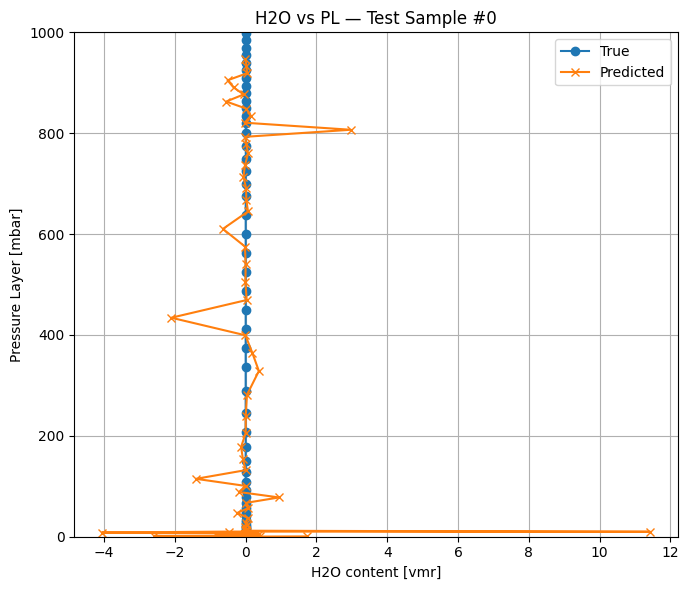

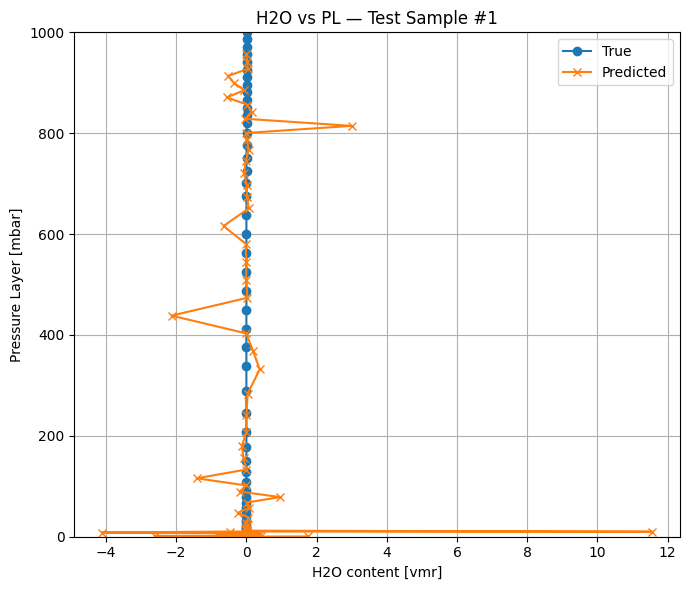

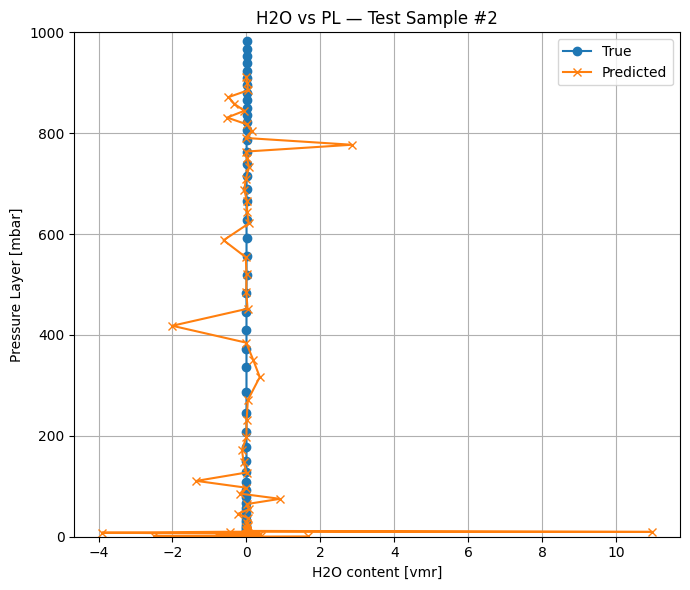

In [30]:
for i in range(3):
    pl_profile_true = PL_true[i]
    h2o_profile_true = H2O_true[i]
    pl_profile_pred = PL_pred[i]
    h2o_profile_pred = H2O_pred[i]

    plt.figure(figsize=(7, 6))
    plt.plot(h2o_profile_true, pl_profile_true, label="True", marker='o')
    plt.plot(h2o_profile_pred, pl_profile_pred, label="Predicted", marker='x')
    plt.gca().invert_yaxis()
    plt.xlabel("H2O content [vmr]")
    plt.ylabel("Pressure Layer [mbar]")
    plt.ylim(0, 1000)
    plt.title(f"H2O vs PL — Test Sample #{i}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()